# Alz specific gene analysis
A recent research on Alzheimer disease at 2019 identified 198 unique genes of interest from both table 1 and supplementary table 13. They are

34 genes from 
   >Table 1: Significantly associated regions identified in the GWAS of AD case-control status, AD-by-proxy phenotype, and meta-analysis

192 genes from 
   >Supplementary Table 13: Genes implicated by positional mapping, eQTL or chromatin interaction mapping of significant GWAS SNPs.

Among them, 6 genes in Table 1 are not covered in S_Table 13, making a total of 198 genes.

This analysis take these regions, cross reference them with the genes that were sequenced in the ROSMAP data set, and then compute the weight and Association stats for it. 


## Method
### Data wrangling and Region list extraction.
Before started,two csv format gene list was extracted from both table 1,via microsoft word OCR, and the downloaded supplemanty table 13 of the paper.

The code used for extractng a region list is shown below. 

The first section correct various mistake in Table 1 that can inhibit the annotation and matching process. Then ensemble ID are attched to table 1 based using "hsapiens_gene_ensembl" data base as table 13 already have ensemble ID comming with it. The checking of both gene name and ensemble ID ensure there is no duplication of genes. 

The genes are then used to compared with both the DLPFC and the PCC.  

162 out of 192 genes are included in the ROSMAP DLPFC gene expression files and 160 are in that of PCC, both are stored for follow up analysis. For the excluded genes, please see:https://github.com/cumc/neuro-twas/issues/20

    The following codes are meant to be ran in a R enviorment with package collection tidyverse installed.

In [ ]:
library(dplyr)
library(readr)
library(tibble)
library(ggplot2)
library("biomaRt")
library(tidyverse)
table_13 = read_csv("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/table_13.csv",skip = 3)%>%janitor::clean_names()%>%dplyr::select(chr,gene,ensembl_id)
table_1 = read_csv("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/table_1.csv",skip = 2)%>%janitor::clean_names()%>%dplyr::select(chr,gene,snp)
table_13 = table_13[1:192,]
table_1[,3]=1
table_1 = table_1%>%na.omit()
# Manual change the error in table_1
#Typo in the paper
table_1$gene[table_1$gene == "INPPD5"] = "INPP5D"
#Alternative name for same genes
table_1$gene[table_1$gene == "AC074212.3"] = "BHMG1"
table_1$gene[table_1$gene == "BZRAP1-AS1"] = "TSPOAP1-AS1"
#Two genes putted together
table_1$gene[table_1$gene == "CLU/PTK2B"] = "CLU"
table_1 = rbind(table_1,c(8,"PTK2B",1))

table_1%>%filter(!gene%in%table_13$gene)

# Annotated the ID for table_1
ensembl = useDataset("hsapiens_gene_ensembl",mart=useMart("ENSEMBL_MART_ENSEMBL"))
ensembl_df <- getBM(attributes=c("ensembl_gene_id","chromosome_name", "start_position", "end_position","external_gene_name"),mart=ensembl)%>%filter(!str_detect(chromosome_name,"CHR"))
table_1_anno = left_join(x = table_1, y = ensembl_df, by = c("gene" = "external_gene_name"))%>%dplyr::select(gene,"ensembl_id" = ensembl_gene_id,chr)
table_1_anno[is.na(table_1_anno$ensembl_id),]

# Remove the * in table_13
str_detect(Name,"\\*")
table_13[str_detect(table_13$gene,"\\*"),] = table_13%>%filter(str_detect(gene,"\\*"))%>%mutate(gene = str_sub(gene,end=-2))


# combined the two table and remove the duplicated. table 1 bring 7 additional genes to table 13
Alz_gene = rbind(table_1_anno,table_13)%>%filter(!duplicated(gene))
Alz_gene

# Find if all the genes present in the ROSMAP dataset

#DLPFC
RSM_DLPFC_gene_list = readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/gene_exp/DLPFC/geneCountsResidualsPlusBaselineAgeGenderAdj_rename.txt","\t")
# A total of 162 genes are present in the DLPFC gene exp
Alz_gene_notIn_DLPFC = Alz_gene%>%filter(!ensembl_id%in%RSM_DLPFC_gene_list$gene_ID)

#PCC

readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/geneTpmResidualsAgeGenderAdj_rename_region_list.txt","\t")

RSM_PCC_gene_list = readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt","\t")
Alz_gene_notIn_PCC = Alz_gene%>%filter(!ensembl_id%in%RSM_PCC_gene_list$gene_ID)


Alz_gene_notIn_PCC[!Alz_gene_notIn_PCC$gene%in%Alz_gene_notIn_DLPFC$gene,]

#AC
RSM_AC_gene_list = readr::read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/geneCountsResidualsAgeGenderAdj.txt"," ")
Alz_gene_notIn_AC = Alz_gene%>%filter(!ensembl_id%in%RSM_AC_gene_list$gene_ID)

# Gene that are only excluded from AC 
Alz_gene_notIn_AC[!Alz_gene_notIn_AC$gene%in%Alz_gene_notIn_PCC$gene,]

# Gene that are excluded from PCC and DLPFC only
Alz_gene_notIn_PCC[!Alz_gene_notIn_PCC$gene%in%Alz_gene_notIn_AC$gene,]

#See what gene from table 1 are excluded, both gene_set
table_1_anno[table_1_anno$ensembl_id%in%Alz_gene_notIn_PCC$ensembl_id,] 
table_1[table_1$gene%in%Alz_gene_notIn_AC$gene,]

#See what gene from table 13 are excluded
table_13[table_13$gene%in%Alz_gene_notIn_PCC$gene,]%>%filter(gene == "EXOC3L2")
table_13[table_13$gene%in%Alz_gene_notIn_AC$gene,]

#Check if the excluded gene have alternative ensemble ID in PCC and DLPFC, and if it was presented(No)
ensembl_df%>%filter(external_gene_name%in%Alz_gene_notIn_PCC$gene,!ensembl_gene_id%in%Alz_gene_notIn_PCC$ensembl_id)
RSM_DLPFC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)%>%filter(gene_ID == "ENSG00000283632")
RSM_PCC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)%>%filter(gene_ID == "ENSG00000283632")
#Check if the excluded gene have alternative ensemble ID in AC, and if it was presented(No)
ensembl_df%>%filter(external_gene_name%in%Alz_gene_notIn_AC$gene,!ensembl_gene_id%in%Alz_gene_notIn_AC$ensembl_id)
RSM_AC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)%>%filter(gene_ID == "ENSG00000283632")


# Export the region list for DLPFC and PCC, AC
RSM_ALZ_gene_DLPFC = RSM_DLPFC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)
RSM_ALZ_gene_DLPFC%>%write_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/DLPFC/RSM_Alz_region_list.txt",delim = "\t")

RSM_ALZ_gene_PCC = RSM_PCC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)
RSM_ALZ_gene_PCC%>%write_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/PCC/RSM_Alz_region_list.txt",delim = "\t")

RSM_ALZ_gene_AC = RSM_AC_gene_list%>%filter(gene_ID%in%Alz_gene$ensembl_id)
RSM_ALZ_gene_AC%>%write_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Rosmap/Data/AC/RSM_Alz_region_list.txt",delim = "\t")



## Weight Computation and association testing
Since the region extracted and the sum stat are availble at the moments. The weight computation and association testing are performed on one go. A workflow are ran for both the DLPFC and the PCC. 

For the study, most parameters are ran using the standard twas_fusion workflow, with the following specifications for the weight computation steps:

    All five models are used.
    A window of 10000 bp beforee and after the gene was used.
   >Positional mapping maps SNPs to genes based on physical distance (within a 10-kb window) from known protein-coding genes in the human reference assembly (GRCh37/hg19).
    
    The cut off p.value of heritability is 0.01
    

In [ ]:
#DLPFC, Full 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_FULL_2 \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 10000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

#DLPFC, SNP 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 6 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &





#PCC, Full
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_Full \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

#PCC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &




#AC, FULL

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_FULL \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &



#AC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb twas_fusion  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &


# Hsq estimation and weight computation using susieR
Since the heritability estimated using the fusion package is systemetically lower than what is discussed in the literture. SusieR is used to estimate the weights and the hsq of each tissue.

In [ ]:
#DLPFC, Full 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_FULL_2 \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 10000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

#DLPFC, SNP 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_DLPFC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 6 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &





#PCC, Full
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_Full \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

#PCC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_PCC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &




#AC, FULL

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_FULL \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --exclude_snp ~/Project/Alz/data/pb_snp \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &



#AC, AD SNP

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion_susie.ipynb susie  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

## Result

### Gene exclusion
At the second step of the workflow, two genes are excluded in the plink stages for DLPFC due to the reason of "All variants excluded". They are ENSG00000077454 and ENSG00000205307. A "All variants excluded" in plink stand for:

>The filtering flags you specified caused every last sample or every last variant to be excluded from the analysis.

Indeed there are no SNP in the chr7: 100562228 ~ 100596129 where ENSG00000205307 and ENSG00000077454 located.

As the ENSG00000205307 is not in the dataset of PCC, only one gene: ENSG00000077454 are excluded in the PCC run.

In [ ]:
Chr7 = read_delim("/mnt/mfs/ctcn/datasets/rosmap/wgs/ampad/variants/snvCombinedPlink/chr7.bim",delim = "\t")
colnames(Chr7)[4] = "Pos"
Chr7%>%filter(Pos>100562228,Pos<100596129)

In [ ]:
### Significant TWAS genes


### Result in Weight computation
#### Distribution of Hsq in DLPFC
Using the aforementioned criteria, there 30 genes out of 160 passed the filtering criteria, a alternative run indicates that when using a window of region +/- 5E6 bp, only 1 additional genes passed the hsq cut off.  

Out of the genes whose weight are not computed, there are only 91 of them have their heritability calculated. The rest (130-91) are excluded due to the the error 
   >"GCTA could not converge, skipping gene"

which actually stand for the fail to to converge in REML algorithm. The author of TWAS/FUSION indicates in https://github.com/gusevlab/fusion_twas/issues/11 that

>the lack of REML convergence is a complicated issue that depends on the scale and complexity of the data. If you are seeing this consistently across phenotypes it likely means your sample size is insufficient to build predictors. 

All the hsq file was combined to produce a hsq table for analysis.

Among all the genes, there are 32 genes that have a pval smaller than 0.01, however 2 of them have negative heritability: ENSG00000106351 and ENSG00000106336. Both located at chromosome 7. Among the rest of them, there are still 26 genes with negative heritability.

There is one gene,ENSG00000213654, with a estimated heritability of 62.4 which have a pval of 0.5, indicating errors from various source. This gene was removed as a outlier in the analysis of the heritability.


In [ ]:
DLPFC_hsq = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/Alz/DLPFC/all_hsq.txt",delim = "\t")
PCC_hsq = read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/Alz/PCC/all_hsq.txt",delim = " ")

data,mean,median,var
<chr>,<dbl>,<dbl>,<dbl>
heritability,0.07975118,0.0277945,0.0142394534
h_SE,0.02740545,0.0198240,0.0004436426
pval,0.09815128,0.0142530,0.0169543887


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



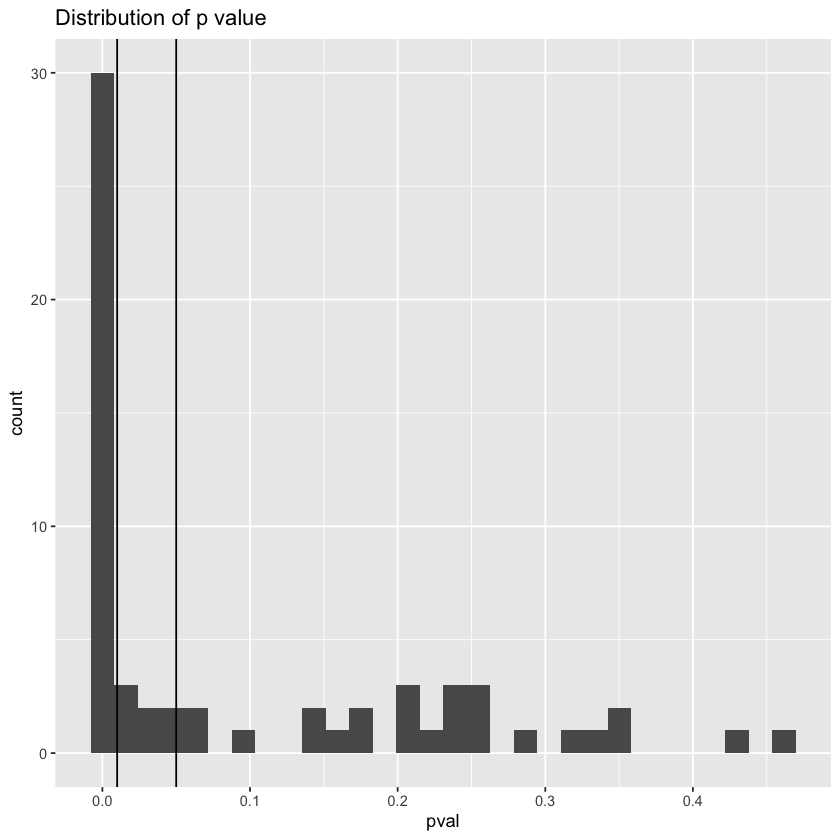

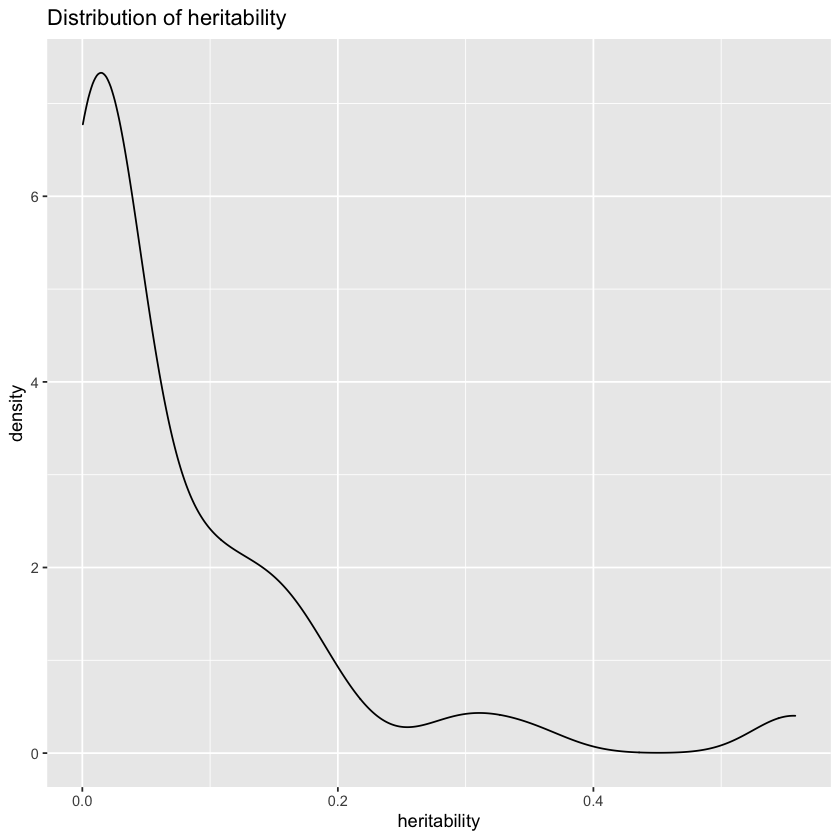

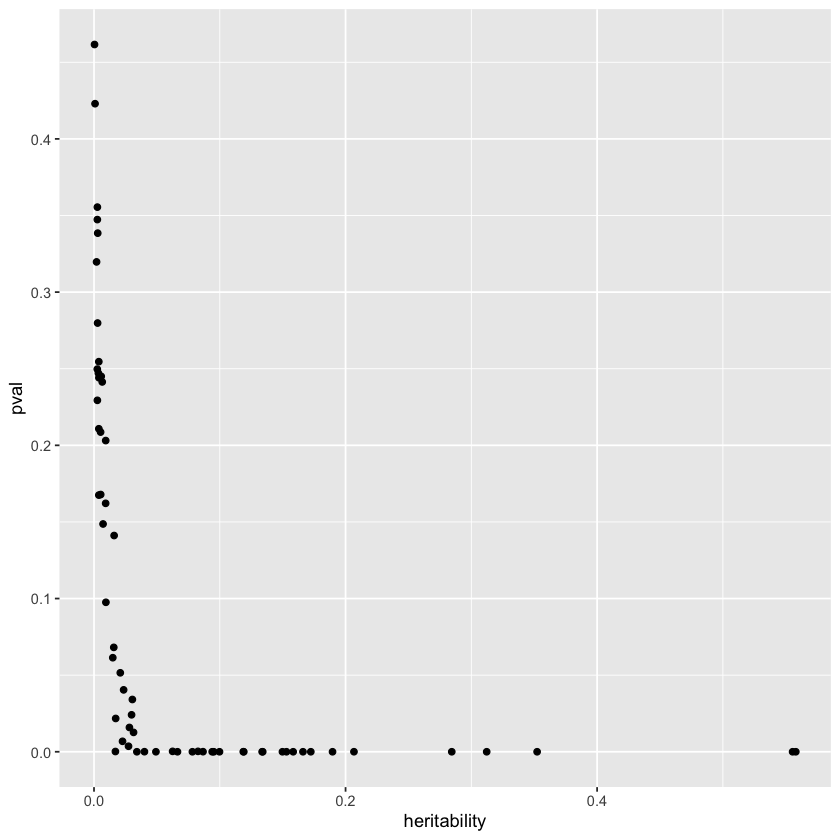

In [48]:
hsq = DLPFC_hsq%>%filter(heritability >= 0, heritability <= 1)
summ = tibble(
  data = c("heritability", "h_SE", "pval"),
  mean = c(
    hsq%>%pull(heritability)%>%mean(),
    hsq%>%pull(h_SE)%>%mean(),
    hsq%>%pull(pval)%>%mean()
  ),
  median = c(
    hsq%>%pull(heritability)%>%median(),
    hsq%>%pull(h_SE)%>%median(),
    hsq%>%pull(pval)%>%median()
    ),
  var = c(
    hsq%>%pull(heritability)%>%var(),
    hsq%>%pull(h_SE)%>%var(),
    hsq%>%pull(pval)%>%var()
  ))
summ
hsq%>%ggplot(aes(x = pval))+geom_histogram()+geom_vline(xintercept = 0.05)+geom_vline(xintercept = 0.01)+ggtitle("Distribution of p value")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability))+geom_density()+ggtitle("Distribution of heritability")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability,y = pval))+geom_point()

#### Distribution of Hsq in PCC
Rather surprisingly, despite of having more converged GCTA result: 115 hsq file, only 6 gene passed the heritability cut off, again All the hsq file was combined to produce a hsq table for analysis. 


data,mean,median,var
<chr>,<dbl>,<dbl>,<dbl>
heritability,0.2560357,0.199877,0.05057330
h_SE,0.2922191,0.287332,0.01173138
pval,0.2295823,0.237730,0.02371846


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



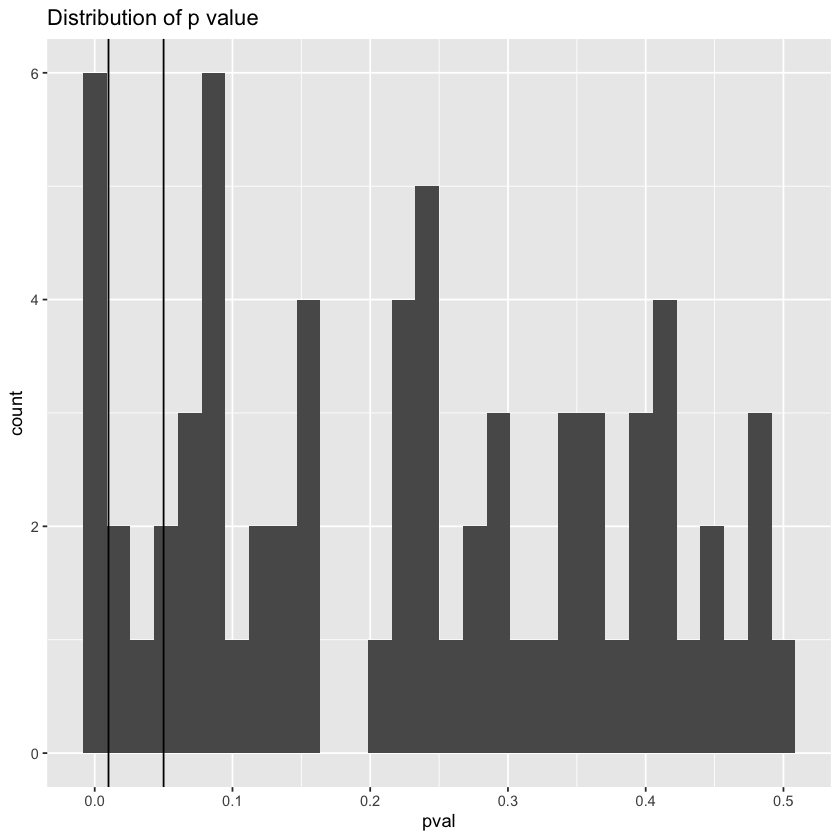

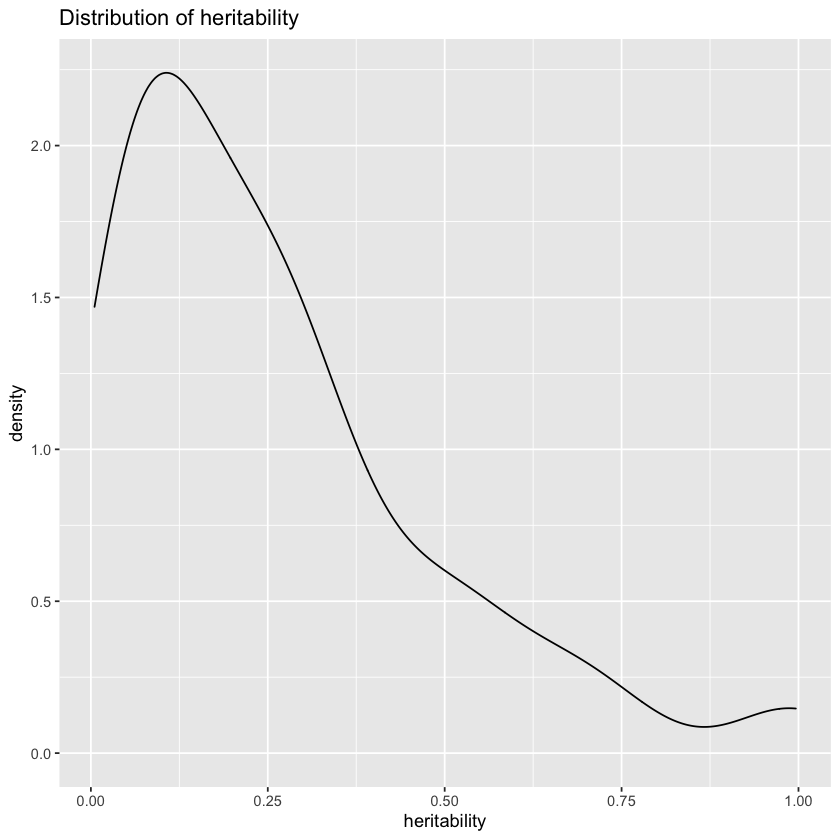

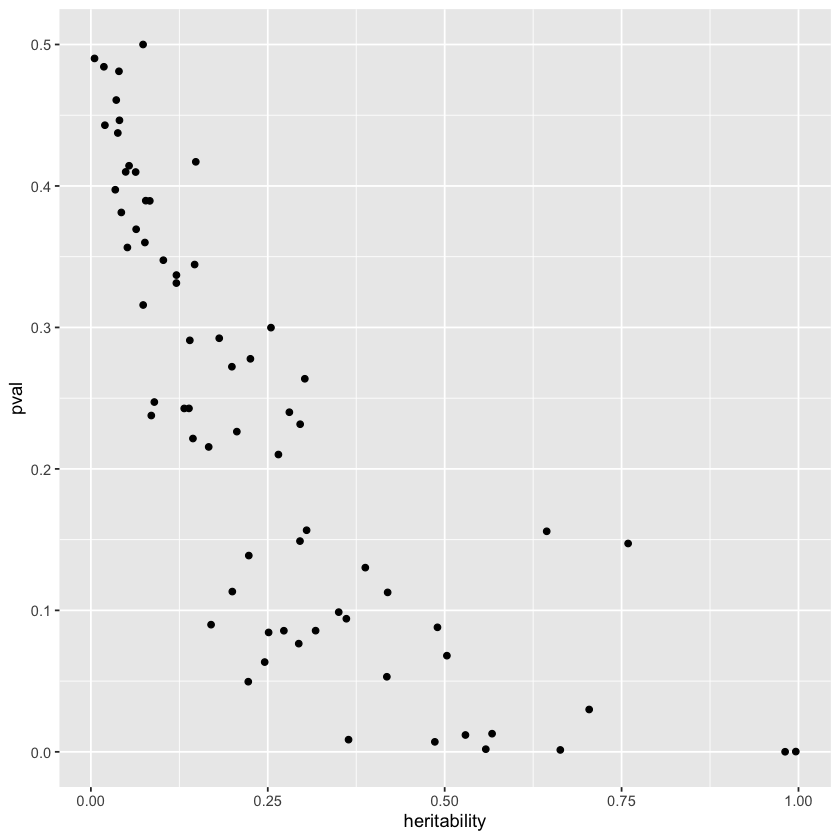

In [49]:
hsq = PCC_hsq%>%filter(heritability >= 0, heritability <= 1)
summ = tibble(
  data = c("heritability", "h_SE", "pval"),
  mean = c(
    hsq%>%pull(heritability)%>%mean(),
    hsq%>%pull(h_SE)%>%mean(),
    hsq%>%pull(pval)%>%mean()
  ),
  median = c(
    hsq%>%pull(heritability)%>%median(),
    hsq%>%pull(h_SE)%>%median(),
    hsq%>%pull(pval)%>%median()
    ),
  var = c(
    hsq%>%pull(heritability)%>%var(),
    hsq%>%pull(h_SE)%>%var(),
    hsq%>%pull(pval)%>%var()
  ))
summ
hsq%>%ggplot(aes(x = pval))+geom_histogram()+geom_vline(xintercept = 0.05)+geom_vline(xintercept = 0.01)+ggtitle("Distribution of p value")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability))+geom_density()+ggtitle("Distribution of heritability")
hsq%>%filter(heritability >= 0, heritability <= 1)%>%ggplot(aes(x = heritability,y = pval))+geom_point()






## Association testing result
The association with the TWAS was produced using the following code.For the DLPFC, there are 22 skipped genes out of the 30 genes. Making a total of 8 genes with TWAS Z score.

For the PCC, there are 5 skipped gene out of six genes.

The error produced for the skipped genes is along the line of
>had 42 / 78 non-overlapping GWAS Z-scores, skipping this gene.

which stand for the fraction of snp in the WGS but not have a sums stat is larger than the  maximum fraction of SNPs allowed to be missing per gene (will be imputed using LD).


TODO：more in depth analysis, including both the strategy for future analysis.


In [14]:
a = tibble(a = 1 , b = 2)
read_delim("/Users/haosun/Documents/WG_Reasearch_Assisstant/Fusion/Project/Alz/DLPFC/all_hsq.txt")



a,b
<dbl>,<dbl>
1,2


In [ ]:
# Supplementary
This section contains analysis that may provide insights.



In [ ]:
# To see what happened in the window of 500000
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_5E6/ \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  -J 10 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

In [ ]:
# To see what happened in the hsq cut off of 0.05
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_005_correct \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/RSM_Alz_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 10000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --asso_mem "60G" \
  --job_size 1\
  --hsq_p 0.05 \
  -J 10 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb association_test  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz \
  --genotype_list /home/hs3163/fake_Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz/data/Alz_passed_gene_region_list.txt \
  --region_name 1 \
  --data_start 2 \
  --output_path /home/hs3163/Project/Alz \
  --window 500000 \
  --container /home/hs3163/system_file/twas_latest.sif \
  --model bslmm blup lasso top1 enet \
  --asso_mem "60G" \
  --job_size 1\
  --weights_list /home/hs3163/fake_weight_list.txt \
  -J 6 -q csg -c ~/GIT/neuro-twas/template/csg.yml -s build &

In [ ]:
library(dplyr)
library(plink2R)


wgt_list = read.table("/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/Alz/Alz_PCC_SNP/WEIGHTS/geneTpmResidualsAgeGenderAdj_rename.weights_list.txt",header = T)
wgt_list$WGT
chr = unique(wgt_list$CHR)
N = nrow(wgt_list)


wgt.file = paste(wgt_list$WGT[wgt_list$CHR == 7])
wgt.file ="/Users/haosun/Documents/WG_Reasearch_Assisstant/Remote_Proj/Alz/Alz_PCC_SNP/WEIGHTS/geneTpmResidualsAgeGenderAdj_rename.ENSG00000085514.wgt.RDat"
wgt_info = attach(wgt.file)

wgt_info$wgt.matrix[,]
wgt_info$wgt.matrix[,wgt_info$mod.best

row.pval = grep( "pval" , rownames(wgt_info$cv.performance) )
mod.best = which.min(apply(wgt_info$cv.performance[row.pval,,drop=F],2,min,na.rm=T))
cur.twasr2pred = wgt.matrix[,mod.best] %*% cur.LD %*% wgt.matrix[,mod.best]



wgt_info$wgt.matrix[,mod.best]


genos = read_plink("",impute="avg")
?read_plink
cur.LD = t(cur.genos) %*% cur.genos / (nrow(cur.genos)-1)


wgt_info


# Citation
    1.Jansen IE, Savage JE, Watanabe K, Bryois J, Williams DM, Steinberg S, Sealock J, Karlsson IK, Hägg S, Athanasiu L, Voyle N, Proitsi P, Witoelar A, Stringer S, Aarsland D, Almdahl IS, Andersen F, Bergh S, Bettella F, Bjornsson S, Brækhus A, Bråthen G, de Leeuw C, Desikan RS, Djurovic S, Dumitrescu L, Fladby T, Hohman TJ, Jonsson PV, Kiddle SJ, Rongve A, Saltvedt I, Sando SB, Selbæk G, Shoai M, Skene NG, Snaedal J, Stordal E, Ulstein ID, Wang Y, White LR, Hardy J, Hjerling-Leffler J, Sullivan PF, van der Flier WM, Dobson R, Davis LK, Stefansson H, Stefansson K, Pedersen NL, Ripke S, Andreassen OA, Posthuma D. Genome-wide meta-analysis identifies new loci and functional pathways influencing Alzheimer’s disease risk  Nature Genetics, 2019 Mar;51(3):404-413. doi: 10.1038/s41588-018-0311-9

In [ ]:
# Test the heritability issue with example data

nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/example/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt  \
  --wd /home/hs3163/Project/example/ \
  --genotype_list /home/hs3163/Project/example/genotype_list.txt \
  --region_list /home/hs3163/Project/example/gene_region_list.txt \
  --region_name 2 \
  --data_start 5 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model top1 \
  --job_size 1\
  --asso_mem "60G" \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &


# Test the heritability issue with same Coord method
#DLPFC, SNP 
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/DLPFC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_same_coord/Alz_DLPFC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz_same_coord/data/RSM_Alz_region_list_DLPFC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &

#PCC, SNP 


nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/PCC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_same_coord/Alz_PCC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz_same_coord/data/RSM_Alz_region_list_PCC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &


#AC, SNP
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb compute_wgt  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz_same_coord/Alz_AC_SNP \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz_same_coord/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 50 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &


#AC, SNP, Problem genes
nohup sos run ~/GIT/neuro-twas/Workflow/twas_fusion.ipynb association_test  \
  --gwas_sumstat /home/hs3163/Project/Alz/data/AD_sumstats_Jansenetal_2019sept_2.txt \
  --molecular-pheno  /home/hs3163/Project/Rosmap/data/gene_exp/AC/geneTpmResidualsAgeGenderAdj_rename.txt  \
  --wd /home/hs3163/Project/Alz/Alz_AC_SNP \
  --output_path /home/hs3163/Project/Alz/Alz_AC_SNP_6 \
  --weights_list /home/hs3163/Project/Alz/Alz_AC_SNP/WEIGHTS/Alt_weight_list.txt \
  --genotype_list /home/hs3163/Project/Rosmap/data/Rosmap_wgs_genotype_list.txt \
  --region_list /home/hs3163/Project/Alz_same_coord/data/RSM_Alz_region_list_AC.txt \
  --region_name 1 \
  --data_start 2 \
  --window 500000 \
  --container /mnt/mfs/statgen/containers/twas_latest.sif \
  --model blup lasso top1 enet \
  --job_size 1\
  --asso_mem "60G" \
  --extract_snp ~/Project/Alz/data/AD_sumstats_SNP \
  -J 5 -q csg -c /mnt/mfs/statgen/pbs_template/csg.yml -s build &





Loading required package: Rcpp

Loading required package: RcppEigen

